# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-vs5moziw
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-vs5moziw
     |████████████████████████████████| 596 kB 4.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65053 sha256=d4561d8f75c98c63cd870e4999d9e0041f0c29ae7b905256d16d31bb4f084aab
  Stored in directory: /tmp/pip-ephem-wheel-cache-l8f86tzv/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.10.0+cu111'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13541, done.
remote: Counting objects: 100% (1042/1042), done.
remote: Compressing objects: 100% (548/548), done.
remote: Total 13541 (delta 646), reused 804 (delta 485), pack-reused 12499
Receiving objects: 100% (13541/13541), 5.80 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (9594/9594), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 1.9 MB/s 
     |████████████████████████████████| 145 kB 8.6 MB/s 
     |████████████████████████████████| 130 kB 50.4 MB/s 
     |████████████████████████████████| 749 kB 42.7 MB/s 
     |████████████████████████████████| 843 kB 35.7 MB/s 
     |████████████████████████████████| 112 kB 52.9 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=171f3292052f9c6d9993e85882f1f255d643c3b2fd8a1171f5db9a4cd0595433
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9b

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

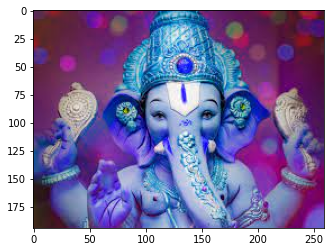

In [ ]:
# TEMP  IMG READ #MINE
ppp = cv2.imread('/content/ganesha.jpeg')
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(ppp)

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [ ]:
# download, decompress the data
!wget https://github.com/D-Emperor/Detectron2_custom/raw/main/data.zip
!unzip data.zip > /dev/null

--2021-11-13 07:51:25--  https://github.com/D-Emperor/Detectron2_custom/raw/main/data.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/D-Emperor/Detectron2_custom/main/data.zip [following]
--2021-11-13 07:51:25--  https://raw.githubusercontent.com/D-Emperor/Detectron2_custom/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3292176 (3.1M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.14M  --.-KB/s    in 0.08s   

2021-11-13 07:51:26 (37.1 MB/s) - ‘data.zip’ saved [3292176/3292176]



Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")

In [ ]:
fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
dataset_dicts = DatasetCatalog.get("fruits_nuts")

WARNING [11/13 07:51:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/13 07:51:43 d2.data.datasets.coco]: Loaded 13 images in COCO format from ./data/trainval.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



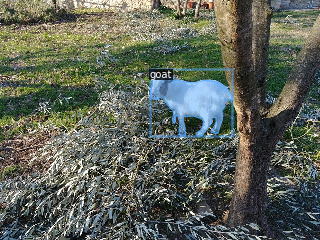

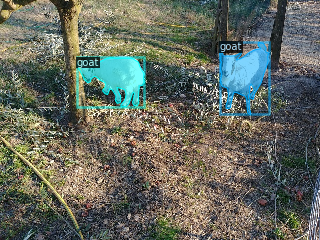

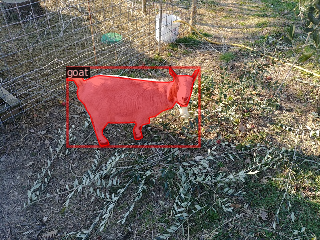

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/13 07:52:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:16, 10.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[11/13 07:53:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/13 07:53:46 d2.utils.events]:  eta: 0:05:32  iter: 19  total_loss: 1.581  loss_cls: 0.4236  loss_box_reg: 0.6336  loss_mask: 0.4201  loss_rpn_cls: 0.001856  loss_rpn_loc: 0.002091  time: 1.1787  data_time: 0.0209  lr: 0.0012854  max_mem: 2338M
[11/13 07:54:11 d2.utils.events]:  eta: 0:05:16  iter: 39  total_loss: 0.5161  loss_cls: 0.05747  loss_box_reg: 0.3472  loss_mask: 0.1091  loss_rpn_cls: 4.494e-05  loss_rpn_loc: 0.003469  time: 1.2160  data_time: 0.0102  lr: 0.0026174  max_mem: 2338M
[11/13 07:54:36 d2.utils.events]:  eta: 0:05:01  iter: 59  total_loss: 0.3499  loss_cls: 0.04346  loss_box_reg: 0.2118  loss_mask: 0.08812  loss_rpn_cls: 0.000212  loss_rpn_loc: 0.00185  time: 1.2314  data_time: 0.0074  lr: 0.0039494  max_mem: 2338M
[11/13 07:55:01 d2.utils.events]:  eta: 0:04:39  iter: 79  total_loss: 0.2617  loss_cls: 0.0316  loss_box_reg: 0.1452  loss_mask: 0.08183  loss_rpn_cls: 0.0001572  loss_rpn_loc: 0.001744  time: 1.2352  data_time: 0.0086  lr: 0.0052814  max_mem: 2338M


Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

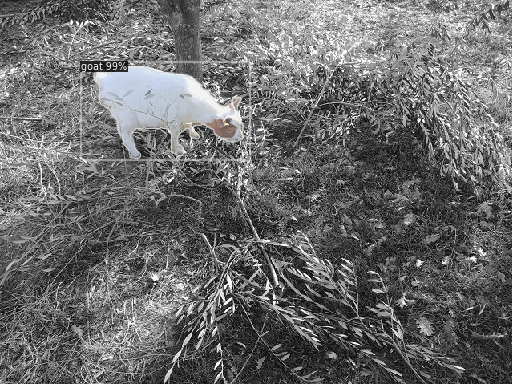

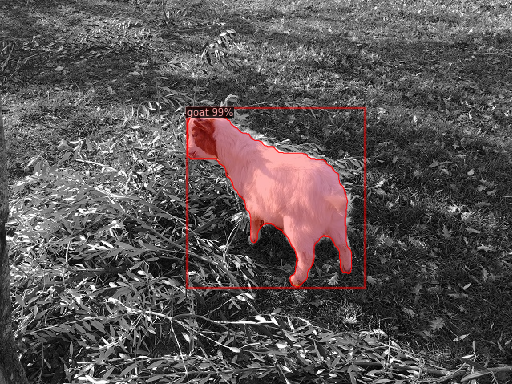

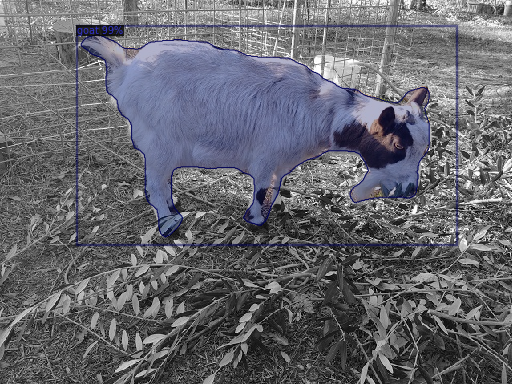

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruits_nuts', thing_classes=['goat'], thing_dataset_id_to_contiguous_id={0: 0})

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.35,fps:2.83


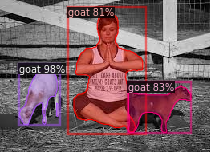

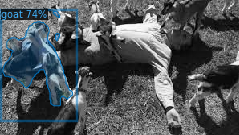

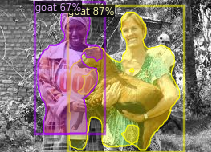

In [32]:
# mine mine
'''from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])''';

#mkmkm = ['/content/goat man.jpeg', '/content/goat person 2.jpeg', '/content/rabbit.jpeg' ]
mkmkm = ['/content/p2.jpeg','/content/p3.jpeg','/content/p4.jpeg']
from detectron2.utils.visualizer import ColorMode

for d in random.sample(mkmkm, 3):    
    im = cv2.imread(d)

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

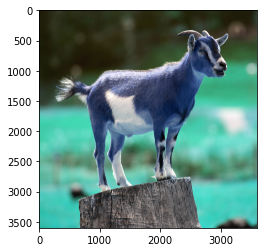

In [ ]:
# TEMP  IMG READ #MINE
ppp = cv2.imread('/content/goat.jpg')
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(ppp)